# Multivariate Time Series Forecasting with LSTMs in Keras
#### Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

### Train On Multiple Lag Timesteps - 1 meter

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
# load dataset
#dataset = read_csv('DFS04690650Rand.txt', header=0, index_col=0)
dataset = read_csv('DFS04690650Rand.txt', header=0, sep='[\t]', parse_dates=True, squeeze=True, dayfirst=True, engine='python')
values = dataset.values
# integer encode direction
#ncoder = LabelEncoder()
#alues[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag periods
n_periods = 4 #4*15min periods; so 1hr
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_periods, 1)
print(reframed.shape)


(20301, 50)


In [4]:
# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
n_obs = n_periods * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_periods, n_features))
test_X = test_X.reshape((test_X.shape[0], n_periods, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(16240, 40) 16240 (16240,)
(16240, 4, 10) (16240,) (4061, 4, 10) (4061,)


Train on 16240 samples, validate on 4061 samples
Epoch 1/16
 - 6s - loss: 0.1580 - val_loss: 0.1429
Epoch 2/16
 - 4s - loss: 0.1434 - val_loss: 0.1423
Epoch 3/16
 - 4s - loss: 0.1429 - val_loss: 0.1421
Epoch 4/16
 - 4s - loss: 0.1429 - val_loss: 0.1421
Epoch 5/16
 - 5s - loss: 0.1427 - val_loss: 0.1421
Epoch 6/16
 - 5s - loss: 0.1426 - val_loss: 0.1422
Epoch 7/16
 - 4s - loss: 0.1424 - val_loss: 0.1422
Epoch 8/16
 - 4s - loss: 0.1424 - val_loss: 0.1421
Epoch 9/16
 - 5s - loss: 0.1423 - val_loss: 0.1420
Epoch 10/16
 - 4s - loss: 0.1422 - val_loss: 0.1419
Epoch 11/16
 - 6s - loss: 0.1421 - val_loss: 0.1419
Epoch 12/16
 - 4s - loss: 0.1421 - val_loss: 0.1419
Epoch 13/16
 - 4s - loss: 0.1421 - val_loss: 0.1419
Epoch 14/16
 - 5s - loss: 0.1420 - val_loss: 0.1419
Epoch 15/16
 - 4s - loss: 0.1420 - val_loss: 0.1419
Epoch 16/16
 - 4s - loss: 0.1420 - val_loss: 0.1419


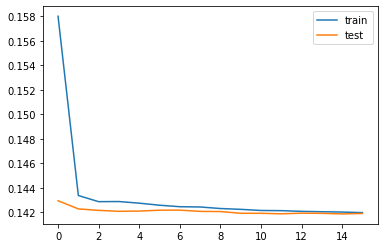

In [5]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=16, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [6]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_periods*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.137
